In [19]:
!pip freeze > requirements.txt

In [20]:
import pandas as pd
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.io import imread_collection, imread
%run readandsubmit.ipynb

ERROR:root:File `'readandsubmit.ipynb.py'` not found.


### Preparing data set

In [21]:
df = readConfigs()
names = readImgNames()

In [22]:
df.head()

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...


In [4]:
total_pics = len(names)
no_class = len(set(names) - set(df["ImageId"].unique()))
class_pics = total_pics - no_class
display(
    f"Total number of pictures is {total_pics}",
    f"Total number of images that has at least one type of fraud {class_pics}",
    f"Total number of fraud instances {df.shape[0]}",
    f"Images that doesn't have a fraud at all {no_class}"
)

'Total number of pictures is 12568'

'Total number of images that has at least one type of fraud 6666'

'Total number of fraud instances 7095'

"Images that doesn't have a fraud at all 5902"

It seems that a lot of picture are not included in frauded list so they seems to be not not damaged. So I decide to print the distribution of target variables and check wheter there is a class disbalance. But first lets check out how is fraud actually represented on the picture.

### Fraud visualization

In [5]:
vis_df = pd.concat([df[df["ClassId"] == 1][:3],
                    df[df["ClassId"] == 2][:3],
                    df[df["ClassId"] == 3][:3],
                    df[df["ClassId"] == 4][:3]])

In [6]:
vis_df

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
8,002fc4e19.jpg,1,146021 3 146275 10 146529 40 146783 46 147038 ...
9,002fc4e19.jpg,2,145658 7 145901 20 146144 33 146386 47 146629 ...
19,008ef3d74.jpg,2,375439 5 375687 14 375935 24 376182 34 376430 ...
22,00ac8372f.jpg,2,98114 24 98370 72 98626 119 98881 168 99137 19...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...
5,0025bde0c.jpg,3,8458 14 8707 35 8963 48 9219 71 9475 88 9731 8...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...


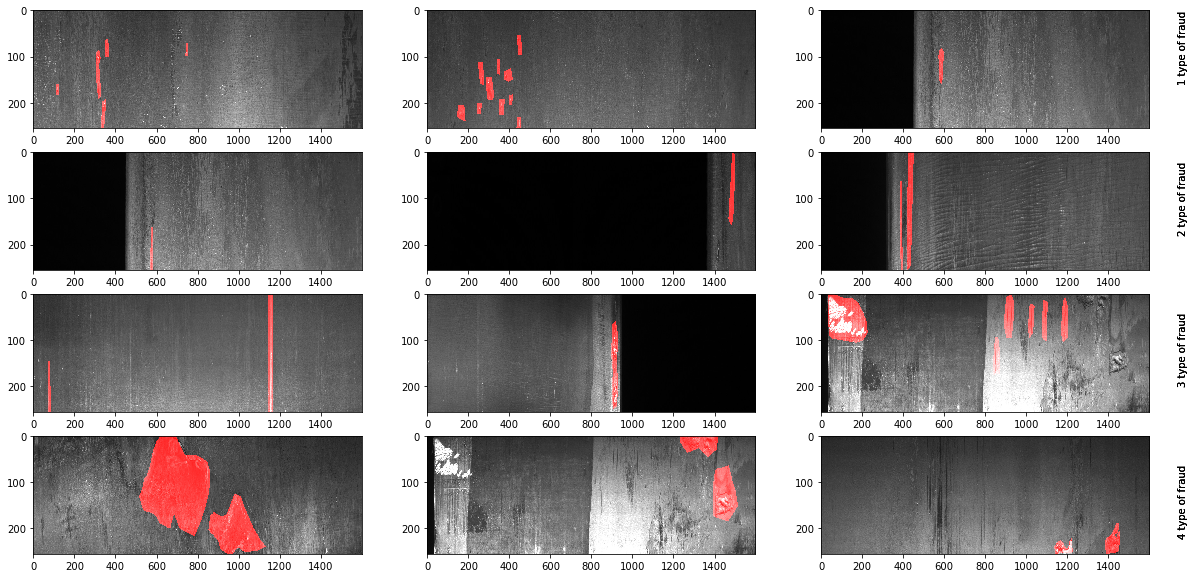

In [18]:
fig, ax = plt.subplots(4,3,figsize=(20,10))
ax = ax.flatten()
    
for inx in range(0,vis_df.shape[0]):
    img = readImg(vis_df.iloc[inx]["ImageId"])
    mask = make_mask_from_rle(np.array(vis_df["EncodedPixels"].iloc[inx].split(" ")).astype(int), 
                              *img.shape[0:2])
    
    img[mask==1,0] = 255
    ax[inx].imshow(img, interpolation='nearest', aspect='auto')

    plt.figtext(.92, .78 - (inx // 3)*0.21, f"{inx // 3 + 1} type of fraud", rotation='vertical')

### Descriptive analysis

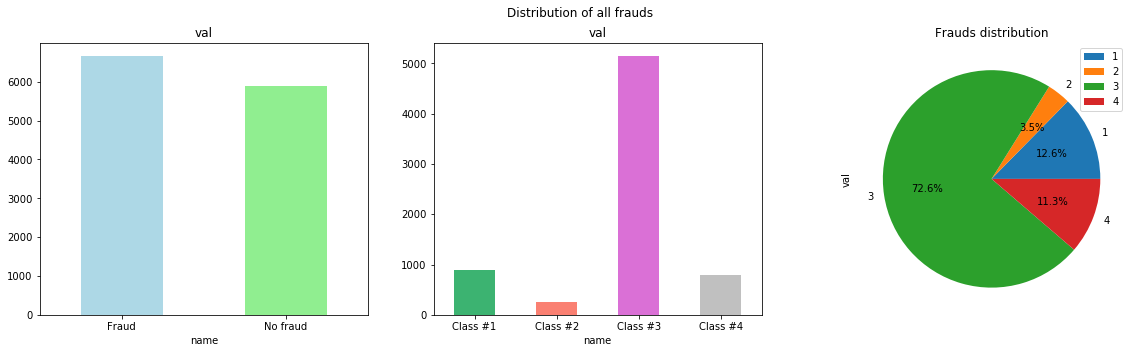

In [123]:
_, ax = plt.subplots(ncols=3,figsize=(20,5))
ax1 = pd.DataFrame({"val":[class_pics, total_pics-class_pics], "name":["Fraud", "No fraud"]});
ax1.plot.bar(y="val",x="name",rot=0,legend=False, color=["lightblue","lightgreen"], subplots=True,ax=ax[0], title="Fraud vs no Fraud bar");

cl1 = df[df["ClassId"] == 1].shape[0]
cl2 = df[df["ClassId"] == 2].shape[0]
cl3 = df[df["ClassId"] == 3].shape[0]
cl4 = df[df["ClassId"] == 4].shape[0]

ax2 = pd.DataFrame({"val":[cl1,cl2,cl3,cl4], "name":[f"Class #{inx}" for inx in range(1,5)]},index=[1,2,3,4])
ax2.plot.bar(y="val",x="name",rot=0,legend=False, color=["mediumseagreen","salmon","orchid","silver"], subplots=True, title="Distribution of all frauds",ax=ax[1]);
ax2.plot(kind="pie",y="val",x="name",autopct='%1.1f%%',ax=ax[2],title="Frauds distribution");

Fraud classes are heavily inbalanced too. Most of frauds are of type 3, type 2 is very rare


One picture might have a couple of regions that has same fraud type. One of papers also suggested to examine how spread each class is.

In [298]:
def count_segments(mask):
    _, threshold = cv2.threshold(np.uint8(mask), 0, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(threshold, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    return len(contours)

In [299]:
df["fraudParts"] = df.apply(lambda x:
                            count_segments(make_mask_from_rle(np.array(x["EncodedPixels"].split(" ")).astype(int))),axis=1)

In [310]:
df["fraudParts"].describe()

count    7095.000000
mean        2.871741
std         2.345878
min         1.000000
25%         1.000000
50%         2.000000
75%         4.000000
max        25.000000
Name: fraudParts, dtype: float64

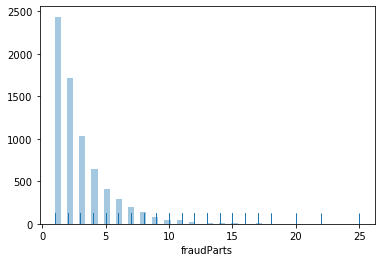

In [309]:
sns.distplot(df["fraudParts"],kde=False,rug=True,label="frauded parts");

It seems like mostly pictures have not more then 5 fraud parts of one type but lets plot it by class.

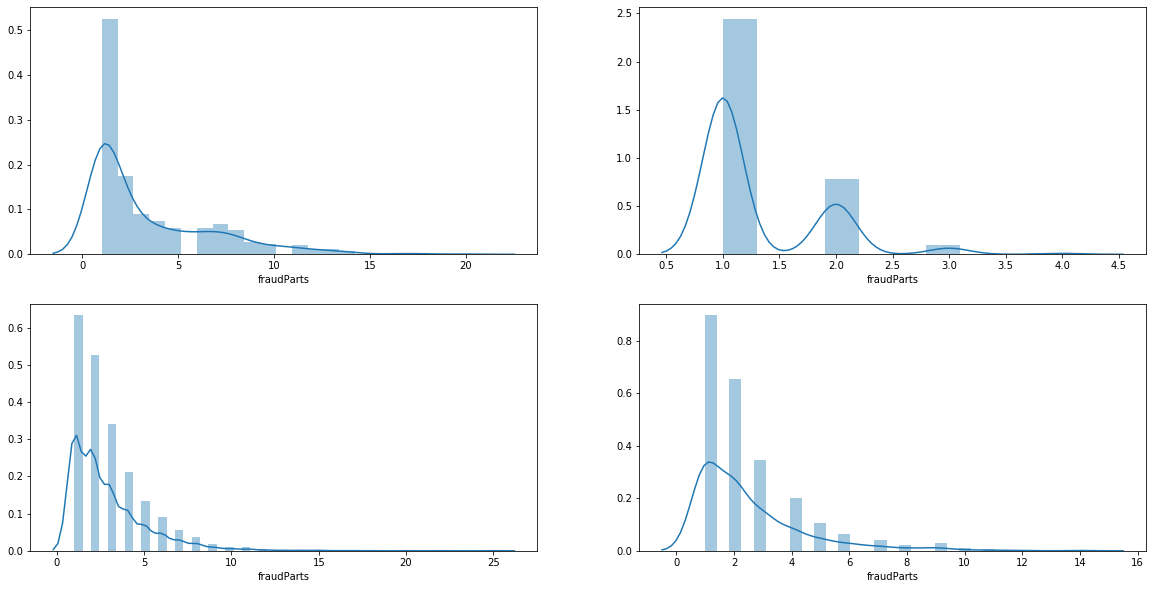

In [316]:
fig, ax = plt.subplots(nrows=2,ncols=2,figsize=(20,10))
ax = ax.flatten()

sns.distplot(df[df["ClassId"] == 1]["fraudParts"], ax=ax[0]);
sns.distplot(df[df["ClassId"] == 2]["fraudParts"], ax=ax[1]);
sns.distplot(df[df["ClassId"] == 3]["fraudParts"], ax=ax[2]);
sns.distplot(df[df["ClassId"] == 4]["fraudParts"], ax=ax[3]);

Class one is the most separated across image, class three(that is the most frequently occured) is mostly in range between 0 and 5. Class two seems two have "clusters" of parts.